In [328]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import re
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import GridSearchCV

print('Done')

Done


# SMALL INTRODUCTION MATERIALS

# visualization of the ship evacuation process: https://www.youtube.com/watch?v=03IAn3TXVOc
# Titanic Deckplans: https://www.encyclopedia-titanica.org/titanic-deckplans/


In [329]:
# Gathering train and test data
XTRAIN = pd.read_csv("input/train.csv")
XTEST = pd.read_csv("input/test.csv")


EXPLORING THE DATA & PLAN PREPROCESSING


In [330]:
# So, in training data we have 891 records with 12 columns.
# 5 of them consist text data

# # Looking at missing data
# a lot of missing data in column Cabin, also some missing in Age

XTRAIN.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [331]:
# for the test data we can see that there is less missing data than in train data
# but also we have only 418 records and 11 cols (no 'Survival')
XTEST.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


<AxesSubplot:xlabel='Sex', ylabel='count'>

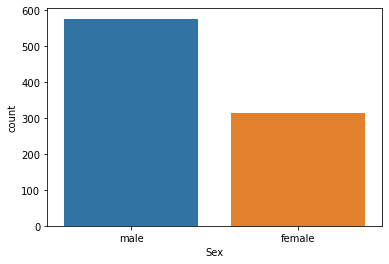

In [332]:
sns.countplot(x="Sex",data=XTRAIN)

<AxesSubplot:xlabel='Parch', ylabel='count'>

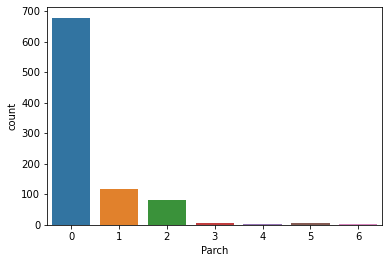

In [333]:
# Parch - parent / child
sns.countplot(x="Parch",data=XTRAIN)

<AxesSubplot:xlabel='SibSp', ylabel='count'>

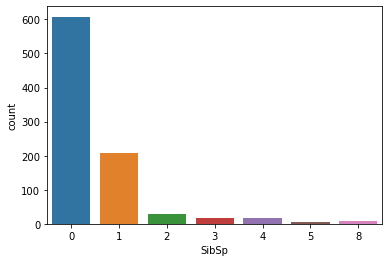

In [334]:
# SibSP - Sibling, spouse (rodzeństwo, małżonek)
sns.countplot(x="SibSp",data=XTRAIN)

<AxesSubplot:xlabel='Pclass', ylabel='count'>

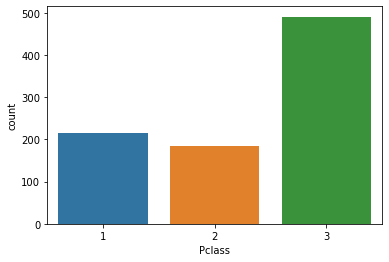

In [335]:
# sns.distplot(x=XTRAIN.Fare,hist=True)
sns.countplot(x="Pclass",data=XTRAIN)

<AxesSubplot:xlabel='Fare', ylabel='count'>

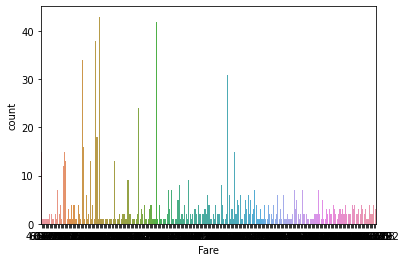

In [336]:
# Fare (opłata)
sns.countplot(x="Fare",data=XTRAIN)

<AxesSubplot:xlabel='Embarked', ylabel='count'>

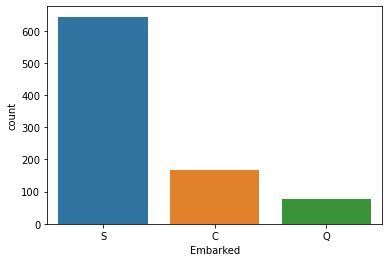

In [337]:
# Embarked - name of the city: S - Southampton, C - Cherbourg, Q - Queenstown (zaokrętowany)
sns.countplot(x="Embarked",data=XTRAIN)

<AxesSubplot:xlabel='Age', ylabel='count'>

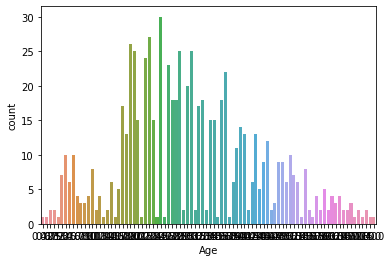

In [338]:
sns.countplot(x="Age",data=XTRAIN)


Correlations between data

<AxesSubplot:>

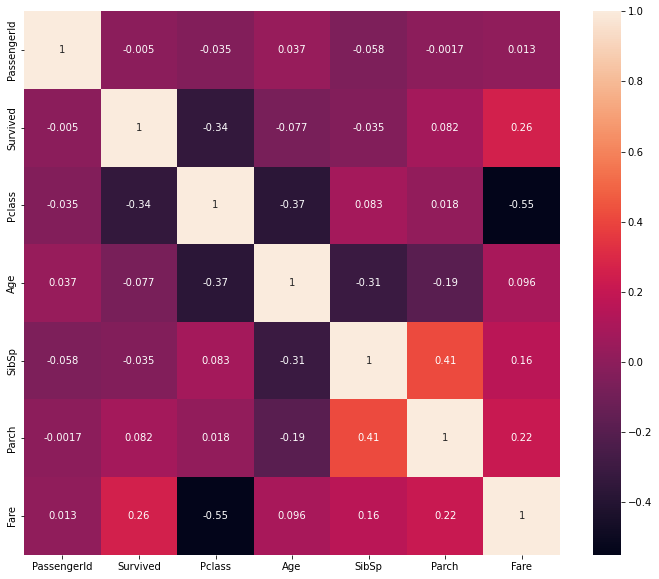

In [339]:
# Heatmap
data_correlations = XTRAIN.corr()
fig, ax = plt.subplots(figsize=(12, 10))

sns.heatmap(data_correlations, annot=True)

# Pclass / Fare - Survived correlation
# Fare - Pclass - neg correlated, one of these could be removed
# Parch - SibSp


<AxesSubplot:xlabel='Sex', ylabel='count'>

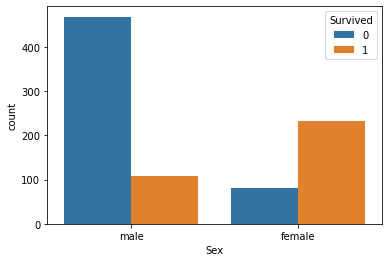

In [340]:
sns.countplot(x="Sex",hue="Survived",data=XTRAIN)

# mostly men died

<AxesSubplot:xlabel='Fare', ylabel='count'>

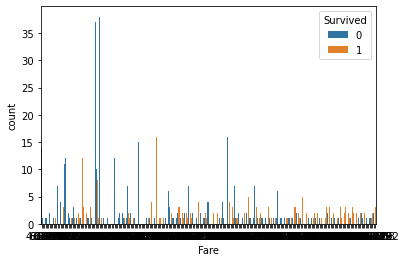

In [341]:
sns.countplot(x="Fare",hue="Survived",data=XTRAIN)

# the lower Fare

<AxesSubplot:xlabel='Pclass', ylabel='count'>

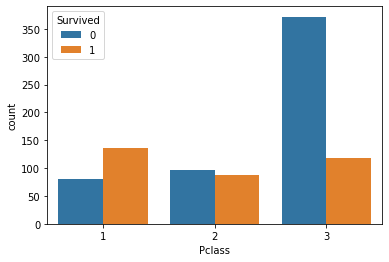

In [342]:
sns.countplot(x="Pclass",hue="Survived",data=XTRAIN)

# mostly people from 3rd class died
# these data is much cleaner than Fare and shows the same

<AxesSubplot:xlabel='SibSp', ylabel='count'>

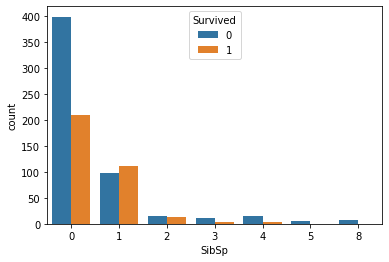

In [343]:
sns.countplot(x="SibSp",hue="Survived",data=XTRAIN)

# most of victims were alone

<AxesSubplot:xlabel='Age', ylabel='count'>

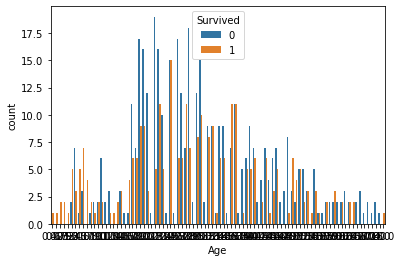

In [344]:
sns.countplot(x="Age",hue="Survived",data=XTRAIN)


In [345]:
XTRAIN.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [346]:
# Preparing data preprocessing

# As we can see, Cabin has only 210 not-null records (out of 891), so it may be dropped as not helpful.
# Let's see more details about nulls:
XTRAIN.isnull().sum()
# Age - has some missing data, let's fill that up with an average
# for missing Embarked we can drop these 2 records

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [347]:
# for the test data we have similar situation with Age, 
# also 1 Fare is missing (will drop that record)
XTEST.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

In [348]:
# Cabin - besides many empty records it also doesn't look like something interesting, will probably drop it completely.
XTRAIN.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [349]:
# Also, columns: Ticket, Name will be dropped as they have only unique strings, so they can't become Categorical columns
# Sex, Embarked - will be converted to Categorical

XTRAIN.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [350]:
XTEST.describe(include='object')

,Name,Sex,Ticket,Cabin,Embarked
count,418,418,418,91,418
unique,418,2,363,76,3
top,"Kelly, Mr. James",male,PC 17608,B57 B59 B63 B66,S
freq,1,266,5,3,270


In [351]:
# Let's see what we can do with missing Embarked values.
# Below you can see that the most frequent value is 'S'.
XTRAIN.Embarked.value_counts()

# Let's fill empty Embarked values with 'S' as this is the most common one.


S    644
C    168
Q     77
Name: Embarked, dtype: int64

In [352]:
# Same for the test data.
XTEST.Embarked.value_counts()

# Name - I will try to findout if being a member of family gave any better chance of survival. 
# Therefore, I will try to export surnames to separate column and then calculate a family size for each member.

# Below we can see that Surname has now 666 unique values of 891 total.
# So, itself it doesn't look like a good Categorical column

S    270
C    102
Q     46
Name: Embarked, dtype: int64


PREPROCESSING DATA


In [353]:
# find surnames in Name column 
def get_surname(name):
    reg = re.compile('([A-Za-z]+),')
    return reg.findall(name)[0]



# let's define function that will do all the preprocessing discussed above
def preprocess_data(df):
    # replace empty ages with an average
    df['Age'].fillna(df["Age"].mean(), inplace=True)

    # fill missing embarked values with the most common one
    df['Embarked'].fillna('S', inplace=True)

    # scaling down Fare numbers
    df["scale_fare"] = df["Fare"]/20

    df["is_child"] = df["Age"]<18
# df['two'].between(-0.5, 0.5, inclusive=False)
#     df["is_young"] = df["Age"].between(18, 35, inclusive=True)
#     df["is_midage"] = df["Age"].between(35, 65, inclusive=False)
#     df["is_old"] = df["Age"]>=65


    # df.drop(['Name', 'Cabin', 'Ticket', 'PassengerId', 'Fare', 'Sex_female', 'Sex_male', 'Age'], axis='columns', inplace=True)

    # dropping rows with empty records
    df.dropna(inplace=True)
    
    # converting Categorical cols into numbers
    df = pd.get_dummies(df, columns=["Pclass","Embarked", "Sex", "is_child"])
    # , "is_midage", "is_young", "is_old"
    df["is_woman"] = df["Sex_female"]
    df["is_child"] = df["is_child_True"]
    # df["is_midage"] = df["is_midage_True"]
    # df["is_young"] = df["is_young_True"]
    # df["is_old"] = df["is_old_True"]
    df["is_class_1"] = df["Pclass_1"]

    # "Pclass_2", "Pclass_3" are neg correlated to Pclass_1

    # PassengerId seems to be just a record ID without any importance - also to be dropped.
    df.drop(['Name', 'Cabin', 'Ticket', 'PassengerId', 'Fare', 'Sex_female', 'Sex_male', 'Age', 'SibSp', 'Parch'], axis='columns', inplace=True)
    df.drop(['Embarked_Q', "Embarked_C", "is_child_True", "is_child_False"], axis='columns', inplace=True)
    # df.drop(["is_midage_True", "is_midage_False", "is_young_True", "is_young_False", "is_old_True", "is_old_False"], axis='columns', inplace=True)
    df.drop(["Pclass_1", "Pclass_2", "Pclass_3"], axis='columns', inplace=True)

    return df

# and run the preprocessing on both train and test data
X = preprocess_data(XTRAIN)
XTEST = preprocess_data(XTEST)

X.head()

,Survived,scale_fare,Embarked_S,is_woman,is_child,is_class_1
1,1,3.564165,0,1,0,1
3,1,2.655000,1,1,0,1
6,0,2.593125,1,0,0,1
10,1,0.835000,1,1,1,0
11,1,1.327500,1,1,0,1


In [354]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 889
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    204 non-null    int64  
 1   scale_fare  204 non-null    float64
 2   Embarked_S  204 non-null    uint8  
 3   is_woman    204 non-null    uint8  
 4   is_child    204 non-null    uint8  
 5   is_class_1  204 non-null    uint8  
dtypes: float64(1), int64(1), uint8(4)
memory usage: 5.6 KB


In [355]:
X.isnull().sum()

Survived      0
scale_fare    0
Embarked_S    0
is_woman      0
is_child      0
is_class_1    0
dtype: int64

In [356]:
XTEST.isnull().sum()

scale_fare    0
Embarked_S    0
is_woman      0
is_child      0
is_class_1    0
dtype: int64

In [357]:

# ANALYZING RELATIONS BETWEEN THE DATA


<AxesSubplot:>

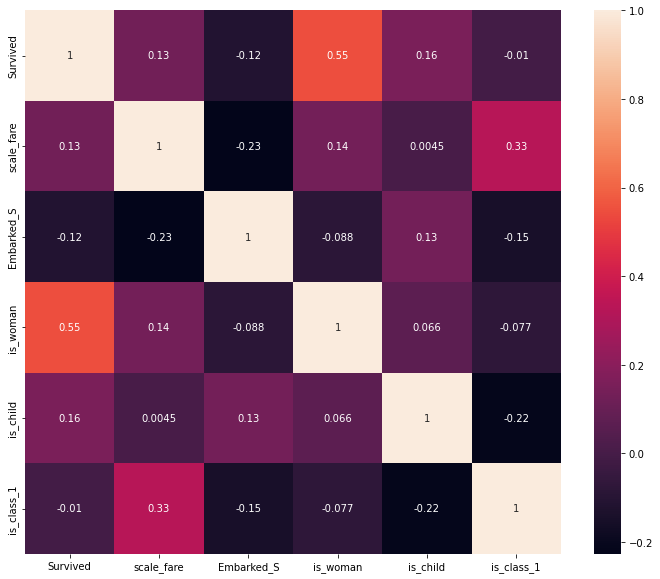

In [358]:
# Heatmap
data_correlations = X.corr()
plt.subplots(figsize=(12, 10))

sns.heatmap(data_correlations, annot=True)

# Fare vs Passenger class neg correlation means that the higher class number the lower the price for it
# we can also see that the correlation between Sex and Survival is not interesting as both male and female got about 50%
# there is quite logical correlation between FamilySize, Sibling/Spouse and Parent/Child (between 60-67%)
# Also interesting but small correlation (26%) between Fare and Survival

In [359]:
# Let's separate target from features
y = X['Survived']
X = X.drop(['Survived'], axis=1)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 204 entries, 1 to 889
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   scale_fare  204 non-null    float64
 1   Embarked_S  204 non-null    uint8  
 2   is_woman    204 non-null    uint8  
 3   is_child    204 non-null    uint8  
 4   is_class_1  204 non-null    uint8  
dtypes: float64(1), uint8(4)
memory usage: 4.0 KB


In [360]:
# Splitting train data
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=0)
X_train.info()
# as we can see the number of records in train data is lower now

<class 'pandas.core.frame.DataFrame'>
Int64Index: 163 entries, 515 to 745
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   scale_fare  163 non-null    float64
 1   Embarked_S  163 non-null    uint8  
 2   is_woman    163 non-null    uint8  
 3   is_child    163 non-null    uint8  
 4   is_class_1  163 non-null    uint8  
dtypes: float64(1), uint8(4)
memory usage: 3.2 KB



# TRAINING & HYPERPARAMS TUNING FOR DIFFERENT MODELS. SELECTING BEST RESULTS

# METHOD 2



In [365]:
# In the mean time I finished a Pluralsight course about Classification Models 
# (Recommended: https://app.pluralsight.com/course-player?clipId=bc93208b-396f-4a58-b8b2-2013933c28da)
# And I learnt another hyperparams tuning implementation using GridSearchCV.

def get_model_name(trained_model_obj):
    reg = re.compile('([A-Za-z]+)\(')
    return reg.findall(trained_model_obj.__str__())[0]


def print_gridcv_results(model, trainedModel):
    results = model.cv_results_
    # print(results)
    best_params = model.best_params_
    
    trained_model_name = get_model_name(trainedModel)

    print('Model: ', trained_model_name)
    for i in range(len(results['mean_fit_time'])):
        if results['params'][i] == best_params:
            print('Params: ', results['params'][i])
            print('Mean score: ', results['mean_test_score'][i])
            print()

            return

# Ensemble Machine Learning Approach
# https://www.datacamp.com/community/tutorials/adaboost-classifier-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9061060&gclid=CjwKCAiA_omPBhBBEiwAcg7smbQQMeHghK-VyfEArRtCwA53E1PErY_NcMUYp7qCJNy_hRerXLHf9RoC4aUQAvD_BwE

from sklearn.ensemble import AdaBoostClassifier
from sklearn.svm import SVC

# svc=SVC(probability=True, kernel='linear')

    # {
    #     'model': KNeighborsClassifier(),
    #     'hyperparams': {
    #         'n_neighbors': range(16, 20, 1),
    #         'n_jobs': range(4, 5, 1),
    #         'leaf_size': range(25, 29, 1)
    #     }
    # },
    # {
    #     'model': DecisionTreeClassifier(),
    #     'hyperparams': {
    #         'max_depth': [1, 2, 3, 4, 5]
    #     }
    # },
    # {
    #     'model': LogisticRegression(solver='liblinear'),
    #     'hyperparams': {
    #         'penalty': ['l1', 'l2'],
    #         'C': [0.7, 0.8, 0.9, 1]
    #     }
    # },
    # {
    #     'model': RandomForestClassifier(),
    #     'hyperparams': {
    #         'n_estimators': range(500, 700, 50),
    #         'n_jobs': range(4, 5, 1),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },
    # {
    #     'model': RandomForestClassifier(n_jobs=4, max_features='auto', bootstrap=False),
    #     'hyperparams': {
    #         'n_estimators': range(40, 46, 1),
    #         'max_depth': range(4, 7, 1)
    #     }
    # },

    # Params:  {'criterion': 'gini', 'max_depth': 8, 'n_estimators': 200, 'n_jobs': 4}
    # Mean score:  0.7852272727272728
    # {
    #     'model': RandomForestClassifier(n_jobs=4, max_features="auto", bootstrap=False),
    #     'hyperparams': {
    #         'criterion' :['gini', 'entropy'],
    #         'n_estimators': range(100, 300, 50),
    #         'n_jobs': range(4, 5, 1),
    #         'max_depth': range(6, 9, 1)
    #     }
    # },
    # {
    #     'model': GradientBoostingClassifier(),
    #     'hyperparams': {
    #         'n_estimators': range(150, 300, 50),
    #         'learning_rate': np.arange(0.01, 0.03, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },

    # Mean score:  0.7791666666666666
    # {
    #     'model': GradientBoostingClassifier(),
    #     'hyperparams': {
    #         'n_estimators': range(250, 800, 50),
    #         'learning_rate': np.arange(0.02, 0.05, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },

    # Params:  {'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 700}
    # Mean score:  0.8287878787878789
    # {
    #     'model': GradientBoostingClassifier(random_state=0, max_features="auto"),
    #     'hyperparams': {
    #         'n_estimators': range(250, 800, 50),
    #         'learning_rate': np.arange(0.02, 0.05, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },


params = [
    #     Params:  {'criterion': 'friedman_mse', 'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 700}
    # Mean score:  0.8287878787878789    # {
    #     'model': GradientBoostingClassifier(random_state=0, max_features="auto"),
    #     'hyperparams': {
    #         'criterion': ['friedman_mse', 'mse', 'mae'],
    #         'n_estimators': range(250, 800, 50),
    #         'learning_rate': np.arange(0.02, 0.05, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },

    # Params:  {'learning_rate': 0.02, 'n_estimators': 300}
    # Mean score:  0.7793560606060606    {
    #     'model': AdaBoostClassifier(),
    #     'hyperparams': {
    #         'n_estimators': range(250, 800, 50),
    #         'learning_rate': np.arange(0.02, 0.05, 0.005)
    #     }
    # },
    # https://www.datacamp.com/community/tutorials/adaboost-classifier-python?utm_source=adwords_ppc&utm_medium=cpc&utm_campaignid=14989519638&utm_adgroupid=127836677279&utm_device=c&utm_keyword=&utm_matchtype=&utm_network=g&utm_adpostion=&utm_creative=278443377095&utm_targetid=dsa-429603003980&utm_loc_interest_ms=&utm_loc_physical_ms=9061060&gclid=CjwKCAiA_omPBhBBEiwAcg7smbQQMeHghK-VyfEArRtCwA53E1PErY_NcMUYp7qCJNy_hRerXLHf9RoC4aUQAvD_BwE
    # {
    #     'model': AdaBoostClassifier(base_estimator=svc),
    #     'hyperparams': {
    #         'n_estimators': range(250, 800, 50),
    #         'learning_rate': np.arange(0.02, 0.05, 0.005),
    #         'algorithm': ['SAMME', 'SAMME.R']
    #     }
    # }
    # {
    #     'model': XGBClassifier(eval_metric='logloss', use_label_encoder=False),
    #     'hyperparams': {
    #         'n_estimators': range(100, 400, 50),
    #         'learning_rate': np.arange(0.04, 0.07, 0.01),
    #         'max_depth': range(7, 10, 1)
    #     }
    # }
    # Params:  {'learning_rate': 0.025, 'max_depth': 4, 'n_estimators': 700, 'validation_fraction': 0.2}
    # Mean score:  0.8287878787878789
    # {
    #     'model': GradientBoostingClassifier(criterion='friedman_mse', random_state=0, max_features="auto"),
    #     'hyperparams': {
    #         'validation_fraction': np.arange(0.2, 1, 0.5),
    #         'n_estimators': range(650, 900, 50),
    #         'learning_rate': np.arange(0.02, 0.035, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # },
    # Model:  SVC
    # Params:  {'C': 0.1, 'decision_function_shape': 'ovo', 'kernel': 'linear', 'max_iter': -0.1, 'shrinking': True}
    # Mean score:  0.66875
    # {
    #     'model': SVC(probability=True, kernel='linear'),
    #     'hyperparams': {
    #         'max_iter': [-0.1, 0.1, 0.2],
    #         'decision_function_shape': ['ovo', 'ovr'],
    #         'shrinking': [True, False],
    #         'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    #         'C': [0.1, 0.5, 1]
    #     }
    # },
    # Model:  GradientBoostingClassifier
    # Params:  {'learning_rate': 0.019999999999999997, 'max_depth': 4, 'n_estimators': 1150, 'validation_fraction': 0.15000000000000002}
    # Mean score:  0.8287878787878789
    # {
    #     'model': GradientBoostingClassifier(),
    #     'hyperparams': {
    #         'validation_fraction': np.arange(0.05, 0.3, 0.05),
    #         'n_estimators': range(850, 1200, 50),
    #         'learning_rate': np.arange(0.01, 0.03, 0.005),
    #         'max_depth': range(3, 6, 1)
    #     }
    # }
    # Model:  GradientBoostingClassifier
    # Params:  {'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 1500}
    # Mean score:  0.8287878787878789
    {
        'model': GradientBoostingClassifier(validation_fraction=0.15),
        'hyperparams': {
            'n_estimators': range(1200, 1700, 50),
            'learning_rate': np.arange(0.005, 0.02, 0.005),
            'max_depth': range(3, 6, 1)
        }
    },
    # {'learning_rate': 0.02, 'max_depth': 4, 'n_estimators': 350}
    # 0.8225378787878789
    {
        'model': GradientBoostingClassifier(random_state=0, max_features="auto", criterion='friedman_mse'),
        'hyperparams': {
            'n_estimators': range(250, 400, 50),
            'learning_rate': np.arange(0.02, 0.05, 0.005),
            'max_depth': range(4, 7, 1)
        }
    }
]

grid_model = {}

for p in params:
    print(get_model_name(p['model']))
    grid_model = GridSearchCV(p['model'], p['hyperparams'], cv=5, n_jobs=4, return_train_score=True, scoring='accuracy', verbose=1)
    grid_model.fit(X_train, y_train)
    # print_gridcv_results(grid_model, p['model'])
    print(grid_model.best_params_)
    print(grid_model.best_score_)

print('Done.')

GradientBoostingClassifier
Fitting 5 folds for each of 90 candidates, totalling 450 fits
{'learning_rate': 0.015, 'max_depth': 4, 'n_estimators': 1200}
0.8227272727272726
GradientBoostingClassifier
Fitting 5 folds for each of 54 candidates, totalling 270 fits
{'learning_rate': 0.045000000000000005, 'max_depth': 4, 'n_estimators': 350}
0.8227272727272726
Done.


In [362]:
# Best performing model along with its hyperparams
# Model:  GradientBoostingClassifier
# Params:  {'learning_rate': 0.019999999999999997, 'max_depth': 4, 'n_estimators': 250}
# Mean score:  0.8300712690139346

# After choosing the best model along with its hyperparams, we do predictions on test data.
model = GradientBoostingClassifier(learning_rate=0.01, max_depth=4, n_estimators=1500)
model.fit(X_train, y_train)
y_pred = model.predict(X_valid)

print('Accuracy score: ', accuracy_score(y_valid, y_pred, normalize=True))
# number of correct predictions
print('Accuracy count: ', accuracy_score(y_valid, y_pred, normalize=False))
print('Precision score: ', precision_score(y_valid, y_pred))
print('Recall score: ', recall_score(y_valid, y_pred))
print()

Accuracy score:  0.7560975609756098
Accuracy count:  31
Precision score:  0.8148148148148148
Recall score:  0.8148148148148148



In [363]:

# HYPERPARAMS TUNING SUMMARY


In [364]:
# As we can see hyperparams chosen in both methods are different, so are the results.
# Hyperparams chosen in Method 1 perform better: at 86% of accuracy (against 83%), 
# therefore they should be used in final data prediction and submission.

y_pred = model.predict(XTEST)
# print_summary(y_valid, y_pred)
print(y_pred)

[1 1 1 1 1 1 1 1 1 1 0 1 0 1 1 0 1 0 1 0 1 0 1 1 1 0 1 1 1 1 1 0 0 0 1 1 1
 0 0 1 1 0 1 1 1 0 1 0 1 1 1 1 1 1 0 1 1 1 0 0 0 0 1 1 0 1 1 0 0 1 1 0 1 1
 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 1 1]
